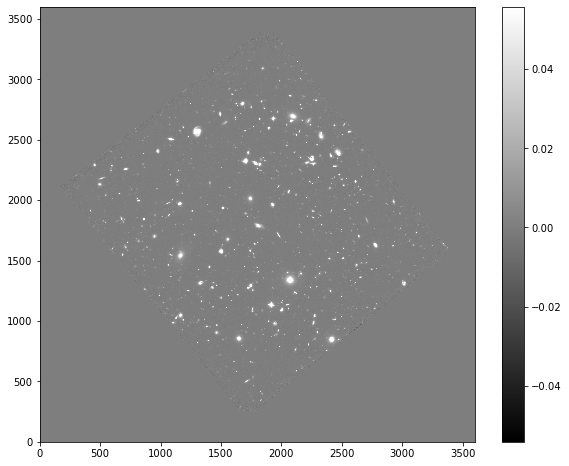

Global Background: 0.0
Global RMS: 0.0005398219218477607


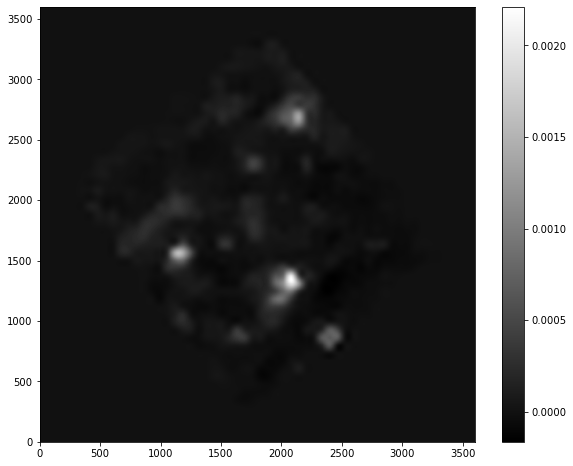

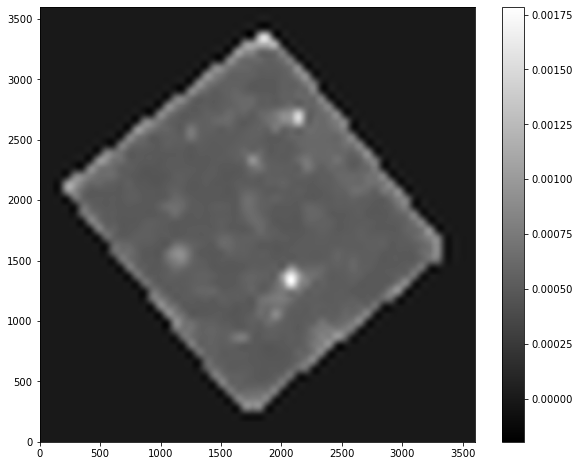

Number of objects detected: 8643


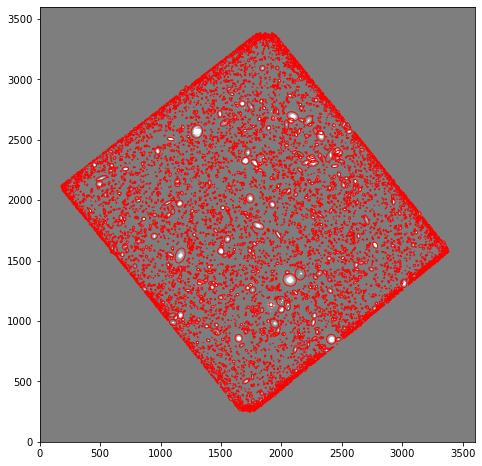

object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877
Number of objects detected: 8643
object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877


In [3]:
import numpy as np
import sep
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import rcParams

%matplotlib inline
rcParams['figure.figsize'] = [10., 8.]

# This reads the image data
file = "hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits"
with fits.open(file) as hdul:
    data = hdul[0].data
    data = data.byteswap().newbyteorder()

# This displays the image
m, s = np.mean(data), np.std(data)
plt.figure(figsize=(10, 8))
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar()
plt.savefig('original_image.png')  # Save the original image
plt.show()

# This measures a spatially varying background on the image
bkg = sep.Background(data)

# Global mean and noise of the image background
print('Global Background:', bkg.globalback)
print('Global RMS:', bkg.globalrms)

# This evaluates the background as a 2D array
bkg_image = bkg.back()

# This displays the background
plt.figure(figsize=(10, 8))
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()
plt.savefig('background.png')  # Save the background image
plt.show()

# This evaluates the background noise as a 2D array
bkg_rms = bkg.rms()

# This displays the background noise
plt.figure(figsize=(10, 8))
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()
plt.savefig('background_noise.png')  # Save the background noise image
plt.show()

# This subtracts the background
data_sub = data - bkg

objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

# Number of objects detected
print("Number of objects detected:", len(objects))

# This plots background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')

# This plots an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

plt.savefig('objects_detected.png')  # Save the objects detected image
plt.show()

# Measure fluxes
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 3.0, err=bkg.globalrms, gain=1.0)

# Display the first 10 objects results
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

# Number of objects detected
num_objects = len(objects)
print("Number of objects detected:", num_objects)

# Measure fluxes
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 3.0, err=bkg.globalrms, gain=1.0)

# Display the first 10 objects results
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))


In [ ]:
# This is the histogram of the fluxes
plt.figure(figsize=(10, 8))
plt.hist(flux, bins='auto', color='blue', alpha=0.7)
plt.title("Histogram of Detected Sources' Fluxes")
plt.xlabel("Flux")
plt.ylabel("Number of Sources")
plt.grid(True)
plt.show()

# This calculates mean, median, and standard deviation of the fluxes
mean_flux = np.mean(flux)
median_flux = np.median(flux)
std_flux = np.std(flux)

print("Mean flux:", mean_flux)
print("Median flux:", median_flux)
print("Standard deviation of flux:", std_flux)

# This identifies the largest outlier
flux_diff_from_mean = np.abs(flux - mean_flux)
num_std_from_mean = flux_diff_from_mean / std_flux
max_std_from_mean = np.max(num_std_from_mean)
largest_outlier_index = np.argmax(num_std_from_mean)
largest_outlier_flux = flux[largest_outlier_index]
largest_outlier_position = (objects['x'][largest_outlier_index], objects['y'][largest_outlier_index])

print("Largest outlier flux:", largest_outlier_flux)
print("Largest outlier position (x, y):", largest_outlier_position)
print("Number of standard deviations from the mean:", max_std_from_mean)

# Function to normalize and scale image data
def scale_img(data):
    m, s = np.mean(data), np.std(data)
    return np.clip((data - m) / s, -1, 1)

# This loads the images
f105w = fits.getdata("hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits")
f125w = fits.getdata("hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits")
f160w = fits.getdata("hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits")

# Scale and normalize the data
f105w_new = scale_img(f105w)
f125w_new = scale_img(f125w)
f160w_new = scale_img(f160w)

# Combine them into a single RGB image
rgb_image = np.dstack((f160w_new, f125w_new, f105w_new))

# This displays the image
plt.figure(figsize=(10, 8))
plt.imshow(rgb_image, origin='lower')
plt.colorbar()
plt.show()

# This saves the image as a PNG file
plt.imsave("hudf_false_color.png", rgb_image, origin='lower')